BTC Price Data Analysis (Percentage Change)

This script performs a basic analysis of BTC/USDT hourly price data, focusing on the behavior of the percentage change in the close price.

## 1. Load Data and Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# Set plot style
sns.set(style="whitegrid")

print("Libraries loaded.")

Libraries loaded.


### Helper Functions

In [3]:
def sma(series, n):
    """Calculates the Simple Moving Average."""
    return series.rolling(window=n).mean()

def awesome_oscillator(high: pd.Series, low: pd.Series, fast_period: int = 5, slow_period: int = 34) -> pd.Series:
    """Calculates the Awesome Oscillator."""
    median_price = (high + low) / 2
    ao = sma(median_price, fast_period) - sma(median_price, slow_period)
    return ao

## 2. Load and Prepare Data

In [4]:
DATA_PATH = 'data/BTCUSDT_1h.csv'
df = pd.read_csv(DATA_PATH)

# Convert to datetime and set as index
df['timestamp'] = pd.to_datetime(df['date'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

print("Data loaded and prepared. Shape:", df.shape)
print(df.head())

Data loaded and prepared. Shape: (88780, 13)
                              unix                 date    symbol   open  \
timestamp                                                                  
2015-02-19 19:00:00  1424372400000  2015-02-19 19:00:00  BTC/USDT  225.0   
2015-02-19 20:00:00  1424376000000  2015-02-19 20:00:00  BTC/USDT  225.0   
2015-02-19 21:00:00  1424379600000  2015-02-19 21:00:00  BTC/USDT  244.0   
2015-02-19 22:00:00  1424383200000  2015-02-19 22:00:00  BTC/USDT  244.0   
2015-02-19 23:00:00  1424386800000  2015-02-19 23:00:00  BTC/USDT  244.0   

                      high    low  close  Volume BTC  Volume USDT  \
timestamp                                                           
2015-02-19 19:00:00  225.0  225.0  225.0    0.999999     0.004444   
2015-02-19 20:00:00  244.0  225.0  244.0   45.275877     0.188671   
2015-02-19 21:00:00  244.0  244.0  244.0    0.000000     0.000000   
2015-02-19 22:00:00  244.0  244.0  244.0    0.000437     0.000002   
2015-02-

## 3. Analyze Close Price Percentage Change

We calculate the percentage change of the closing price. This normalizes the price changes and is a standard way to analyze financial time series. It's also a crucial step for time series modeling, as models like ARIMA often require stationary data.

In [22]:
# Calculate the percentage change in the closing price
df['close_pct_change'] = (df['close'].pct_change()) * 100

# Drop the first row with a NaN value resulting from the pct_change operation
df.dropna(subset=['close_pct_change'], inplace=True)

print("Close price percentage change calculated.")
print(df[['close', 'close_pct_change']].abs().describe())

Close price percentage change calculated.
               close  close_pct_change
count   88778.000000      88778.000000
mean    22258.436673          0.480765
std     24786.077849          0.865381
min        99.000000          0.000000
25%      3472.664706          0.094828
50%     10228.806966          0.256391
75%     36400.155000          0.575068
max    108241.180000        132.323232


### 3.1. Time Series Plot of Price Percentage Change

Plotting the close price percentage change over time...


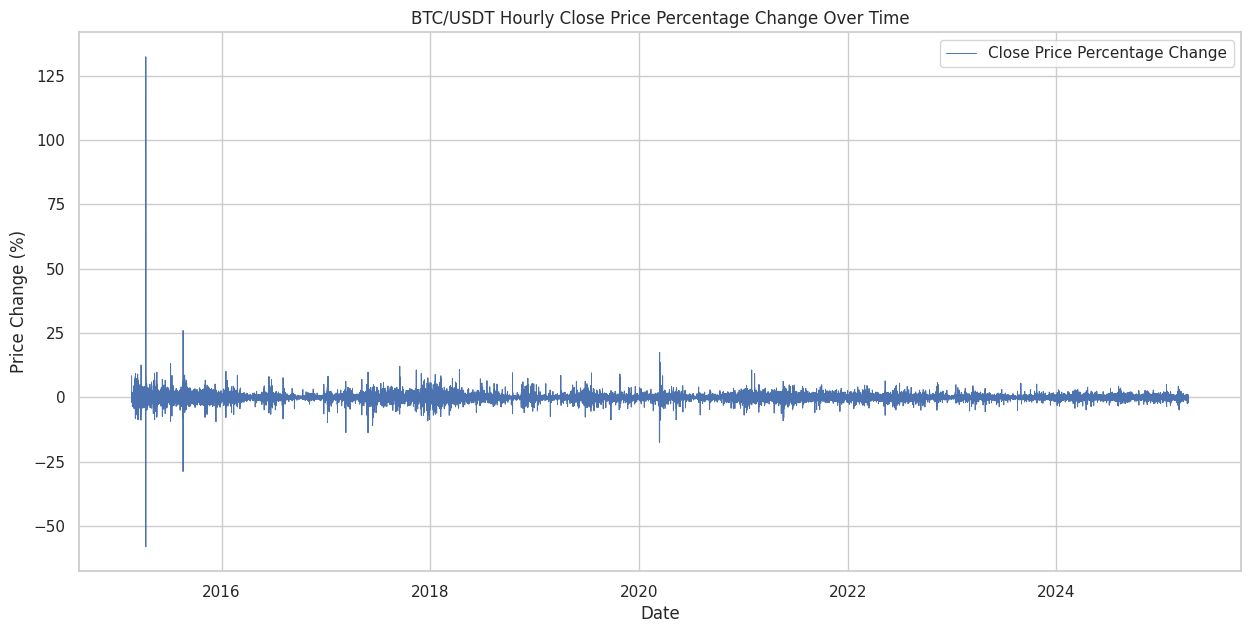

In [6]:
print("Plotting the close price percentage change over time...")
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close_pct_change'], label='Close Price Percentage Change', linewidth=0.7)
plt.title('BTC/USDT Hourly Close Price Percentage Change Over Time')
plt.xlabel('Date')
plt.ylabel('Price Change (%)')
plt.legend()
plt.show()

The plot shows that the percentage change is centered around zero but exhibits volatility clustering—periods of high volatility are followed by more high volatility, and vice versa.

### 3.2. Distribution of Price Percentage Change

Plotting the distribution of the close price percentage change...


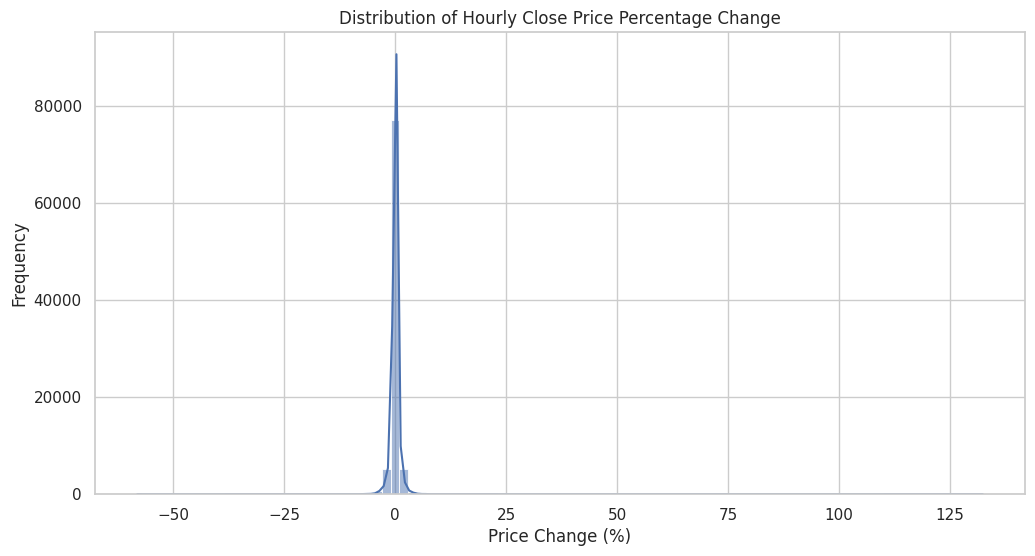

In [7]:
print("Plotting the distribution of the close price percentage change...")
plt.figure(figsize=(12, 6))
sns.histplot(df['close_pct_change'], bins=100, kde=True)
plt.title('Distribution of Hourly Close Price Percentage Change')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.show()

The distribution is highly leptokurtic (sharply peaked at zero with heavy tails), which is a classic characteristic of financial returns. This indicates that extreme price changes occur more frequently than a normal distribution would predict.

### 3.3. Descriptive Statistics

In [8]:
print("Descriptive Statistics for Close Price Percentage Change:")
print(df['close_pct_change'].describe())

Descriptive Statistics for Close Price Percentage Change:
count    88779.000000
mean         0.011197
std          0.990297
min        -58.028204
25%         -0.242369
50%          0.000000
75%          0.269917
max        132.323232
Name: close_pct_change, dtype: float64


The mean is very close to zero. The standard deviation confirms the significant volatility, and the min/max values highlight the extreme hourly percentage swings present in the data.

### 3.4. Stationarity Test (Augmented Dickey-Fuller)

We perform an ADF test to formally check if the percentage change series is stationary. The null hypothesis is that the series is non-stationary.

In [9]:
print("Performing Augmented Dickey-Fuller (ADF) test for stationarity...")
adf_result = adfuller(df['close_pct_change'])

print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value:.3f}')

if adf_result[1] <= 0.05:
    print("\nResult: The series is stationary (p-value <= 0.05).")
else:
    print("\nResult: The series is not stationary (p-value > 0.05).")

Performing Augmented Dickey-Fuller (ADF) test for stationarity...
ADF Statistic: -36.1781
p-value: 0.0000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567

Result: The series is stationary (p-value <= 0.05).


The extremely low p-value allows us to confidently reject the null hypothesis, confirming that the percentage change series is stationary. This is a suitable input for time series models.

### 3.5. Zoomed-in Histogram of Price Percentage Change

Plotting the zoomed-in distribution for price changes between -0.1% and 0.1%...


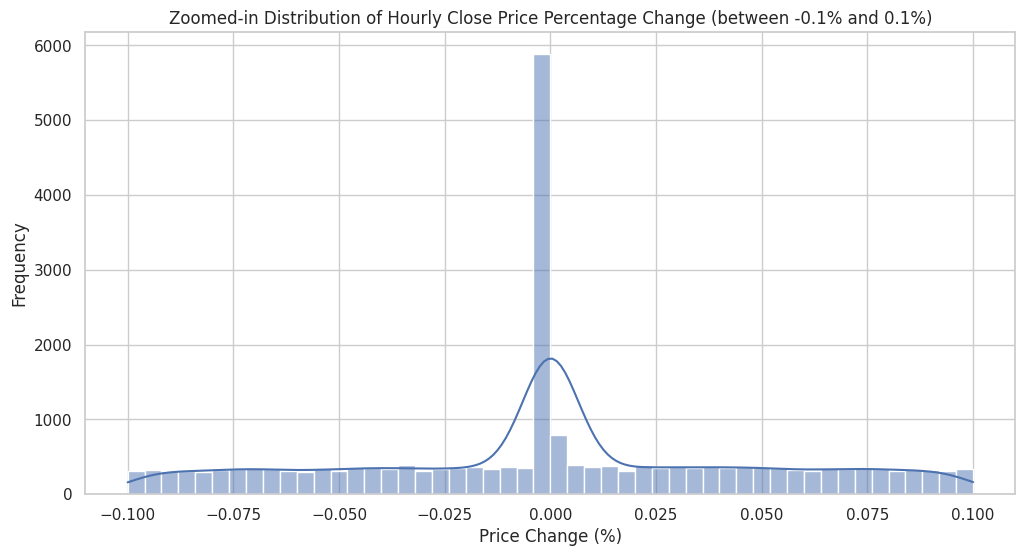

In [10]:
print("Plotting the zoomed-in distribution for price changes between -0.1% and 0.1%...")
zoomed_data = df['close_pct_change'].loc[(df['close_pct_change'] >= -0.1) & (df['close_pct_change'] <= 0.1)]

plt.figure(figsize=(12, 6))
sns.histplot(zoomed_data, bins=50, kde=True)
plt.title('Zoomed-in Distribution of Hourly Close Price Percentage Change (between -0.1% and 0.1%)')
plt.xlabel('Price Change (%)')
plt.ylabel('Frequency')
plt.show()

Zooming in on the vast majority of the data, we can see the distribution around zero more clearly.

### 3.6. Cumulative Distribution of Absolute Price Change

Plotting the Cumulative Distribution Function (CDF) of absolute percentage changes...


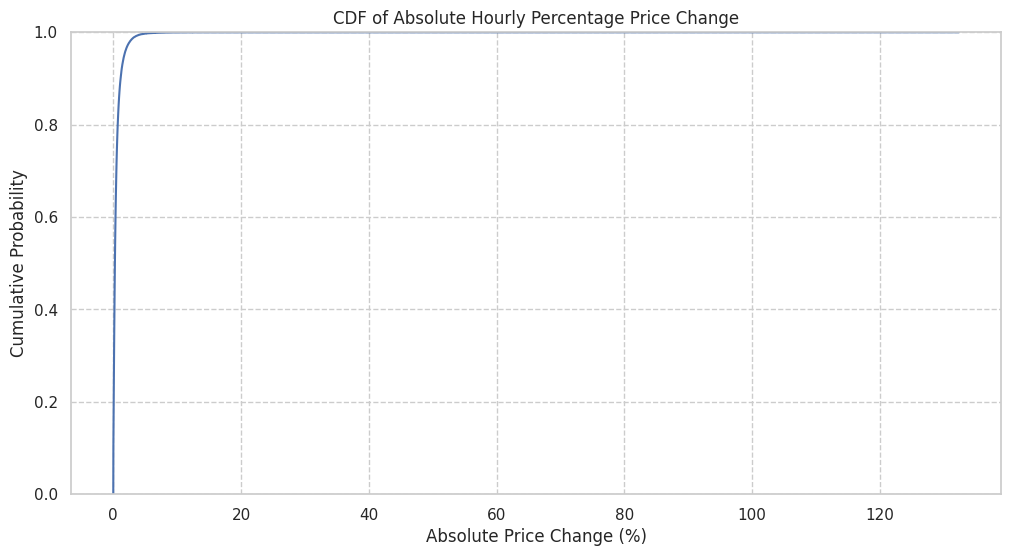

In [11]:
print("Plotting the Cumulative Distribution Function (CDF) of absolute percentage changes...")
df['abs_close_pct_change'] = df['close_pct_change'].abs()

plt.figure(figsize=(12, 6))
sns.ecdfplot(df['abs_close_pct_change'])
plt.title('CDF of Absolute Hourly Percentage Price Change')
plt.xlabel('Absolute Price Change (%)')
plt.ylabel('Cumulative Probability')
plt.grid(True, which="both", ls="--")
plt.show()

The CDF plot shows the probability of observing a price change of a certain magnitude or less. For example, you can use it to find the value on the x-axis that corresponds to 0.95 on the y-axis to see what magnitude of price change accounts for 95% of all hourly movements.

## 4. Awesome Oscillator Analysis

We will now analyze the Awesome Oscillator (AO). We'll compute it in two ways:
1. Using the raw `High` and `Low` prices.
2. Using the percentage change of the `High` and `Low` prices.

This comparison will help visualize how the oscillator behaves on the price series versus the returns series.

In [12]:
# Calculate AO on raw prices
print("Calculating Awesome Oscillator on raw prices...")
df['ao_price'] = awesome_oscillator(df['high'], df['low'])

# Calculate AO on percentage change
print("Calculating Awesome Oscillator on price percentage changes...")
df['high_pct_change'] = df['high'].pct_change()
df['low_pct_change'] = df['low'].pct_change()

# Fill NaNs created by pct_change for AO calculation
high_pct_change_filled = df['high_pct_change'].fillna(0)
low_pct_change_filled = df['low_pct_change'].fillna(0)
df['ao_pct_change'] = awesome_oscillator(high_pct_change_filled, low_pct_change_filled)

print("Awesome Oscillators calculated.")
print(df[['ao_price', 'ao_pct_change']].head())

Calculating Awesome Oscillator on raw prices...
Calculating Awesome Oscillator on price percentage changes...
Awesome Oscillators calculated.
                     ao_price  ao_pct_change
timestamp                                   
2015-02-19 20:00:00       NaN            NaN
2015-02-19 21:00:00       NaN            NaN
2015-02-19 22:00:00       NaN            NaN
2015-02-19 23:00:00       NaN            NaN
2015-02-20 00:00:00       NaN            NaN


### 4.1. Plotting Awesome Oscillators

Plotting Awesome Oscillators for comparison...


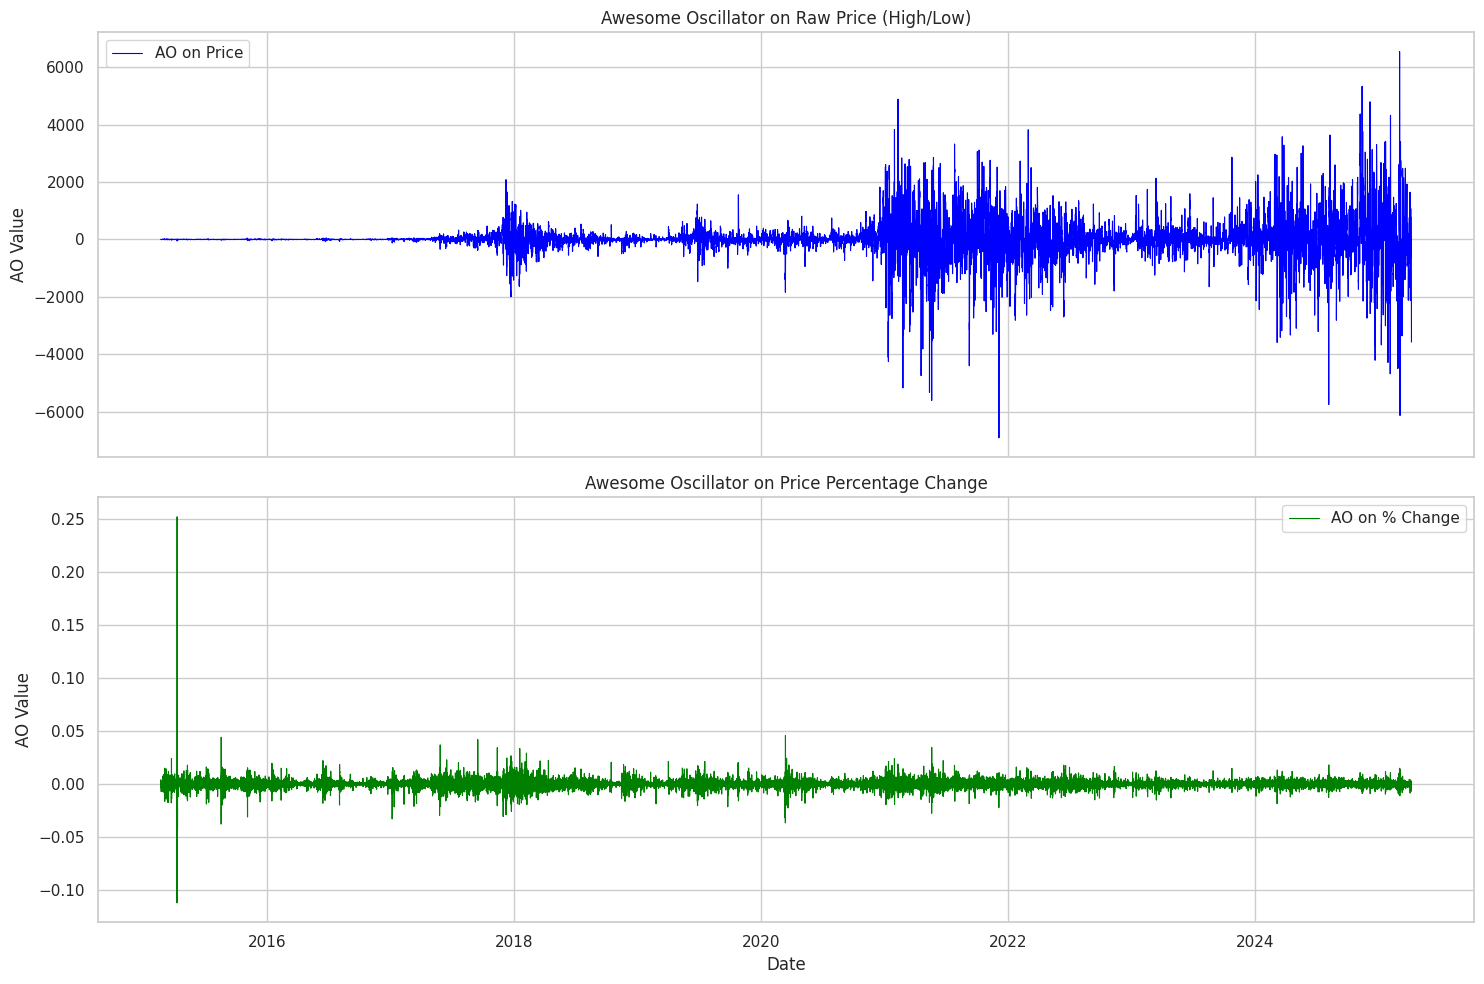

In [13]:
print("Plotting Awesome Oscillators for comparison...")
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot AO on price
axes[0].plot(df.index, df['ao_price'], label='AO on Price', color='blue', linewidth=0.8)
axes[0].set_title('Awesome Oscillator on Raw Price (High/Low)')
axes[0].set_ylabel('AO Value')
axes[0].grid(True)
axes[0].legend()

# Plot AO on percentage change
axes[1].plot(df.index, df['ao_pct_change'], label='AO on % Change', color='green', linewidth=0.8)
axes[1].set_title('Awesome Oscillator on Price Percentage Change')
axes[1].set_ylabel('AO Value')
axes[1].grid(True)
axes[1].legend()

plt.xlabel('Date')
fig.tight_layout()
plt.show()

The plots show a stark difference. The AO on raw prices reflects longer-term price trends and momentum, with large swings. The AO on percentage change is much more stationary and centered around zero, reflecting the short-term volatility and returns behavior rather than the price level itself.

## 5. Consecutive Runs Analysis

Here, we analyze the length of consecutive periods of positive or negative price changes. A "run" is a sequence of one or more hours where the price change has the same sign. For example:
- A single hour of gains is a run of `+1`.
- Three consecutive hours of gains is a run of `+3`.
- Two consecutive hours of losses is a run of `-2`.

This analysis can help identify if there is momentum or mean-reversion behavior in the short term.

In [14]:
print("Analyzing consecutive runs of positive and negative price changes...")

# Determine the sign of the price change, treating 0 as neutral
signs = np.sign(df['close_pct_change'])
# We replace 0s with the previous sign to not break a run
signs = signs.replace(0, np.nan).ffill().fillna(0)

# Identify blocks of consecutive signs
blocks = signs.diff().ne(0).cumsum()

# Calculate the length of each run and multiply by its sign
runs = signs.groupby(blocks).apply(lambda x: x.size * x.iloc[0] if x.iloc[0] != 0 else 0)

# Filter out any zero-runs that might have occurred at the beginning
runs = runs[runs != 0]

print("Consecutive runs calculated. Descriptive statistics:")
print(runs.describe())

Analyzing consecutive runs of positive and negative price changes...
Consecutive runs calculated. Descriptive statistics:
count    45632.000000
mean         0.052003
std          2.587521
min        -45.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max         69.000000
Name: close_pct_change, dtype: float64



Plotting the histogram of consecutive runs...


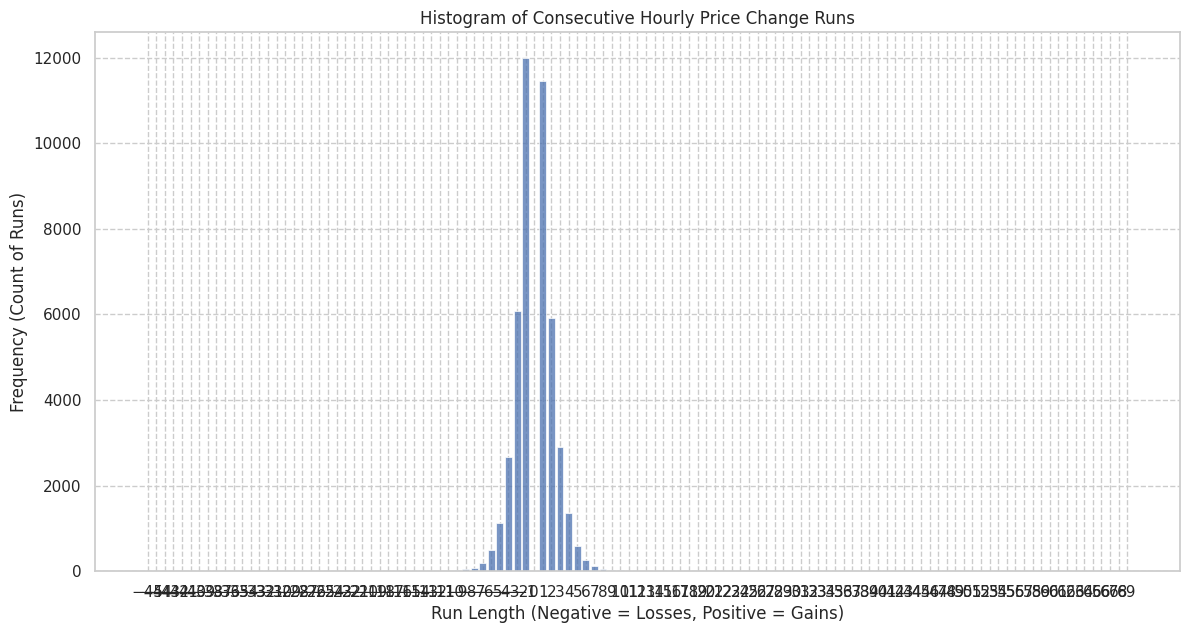

In [15]:
# Plot a histogram of the runs
print("\nPlotting the histogram of consecutive runs...")
plt.figure(figsize=(14, 7))
sns.histplot(runs, discrete=True, stat="count", shrink=0.8)
plt.title('Histogram of Consecutive Hourly Price Change Runs')
plt.xlabel('Run Length (Negative = Losses, Positive = Gains)')
plt.ylabel('Frequency (Count of Runs)')
plt.xticks(np.arange(int(runs.min()), int(runs.max()) + 1, 1))
plt.grid(True, which="both", ls="--")
plt.show()

The histogram shows that short runs (of length 1, 2, or 3) are very common, while long streaks of consecutive gains or losses are increasingly rare. This is consistent with the behavior of a volatile asset where the direction can change frequently.

### 5.1. Run Transition Probability Analysis

Now, we'll analyze the probability of transitioning from a run of one length to another. For example, what is the likelihood that a 1-hour run of gains is followed by a 1-hour run of losses? This can be modeled as a Markov chain, and we can compute the transition matrix.

We will focus on transitions between runs of length -5 to +5.

In [16]:
print("Calculating run transition probabilities...")
# Create a DataFrame of consecutive run pairs
transitions = pd.DataFrame({'from': runs, 'to': runs.shift(-1)}).dropna()
transitions = transitions.astype(int)

# Create a transition count matrix using crosstab
transition_counts = pd.crosstab(transitions['from'], transitions['to'])

# Calculate transition probabilities by dividing each row by its sum
transition_probabilities = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Filter and reindex to focus on the -5 to +5 range, filling missing transitions with 0
run_range = range(-5, 6)
# Remove 0 from the range as it's not a valid run length in our data
run_range = [i for i in run_range if i != 0]

transition_matrix = transition_probabilities.reindex(index=run_range, columns=run_range, fill_value=0)

print("Transition Matrix (-5 to +5):")
print(transition_matrix.to_string(float_format="%.3f"))

Calculating run transition probabilities...
Transition Matrix (-5 to +5):
to      -5    -4    -3    -2    -1     1     2     3     4     5
from                                                            
-5   0.000 0.000 0.000 0.000 0.000 0.505 0.255 0.122 0.050 0.024
-4   0.000 0.000 0.000 0.000 0.000 0.493 0.265 0.119 0.059 0.022
-3   0.000 0.000 0.000 0.000 0.000 0.509 0.255 0.123 0.058 0.029
-2   0.000 0.000 0.000 0.000 0.000 0.489 0.263 0.136 0.064 0.024
-1   0.000 0.000 0.000 0.000 0.000 0.513 0.260 0.124 0.058 0.026
 1   0.020 0.047 0.119 0.267 0.534 0.000 0.000 0.000 0.000 0.000
 2   0.025 0.051 0.112 0.265 0.526 0.000 0.000 0.000 0.000 0.000
 3   0.020 0.052 0.114 0.280 0.515 0.000 0.000 0.000 0.000 0.000
 4   0.021 0.059 0.122 0.254 0.521 0.000 0.000 0.000 0.000 0.000
 5   0.030 0.047 0.111 0.276 0.501 0.000 0.000 0.000 0.000 0.000



Plotting the transition probability heatmap...


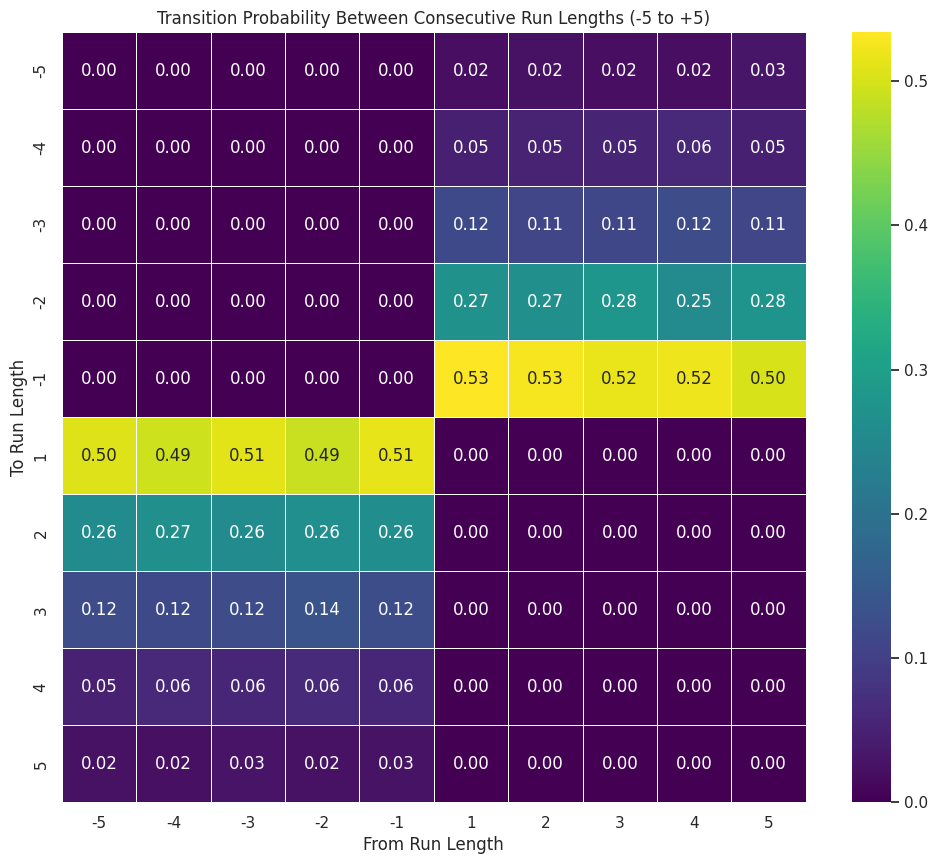

In [17]:
# Plot the transition matrix as a heatmap
print("\nPlotting the transition probability heatmap...")
plt.figure(figsize=(12, 10))
sns.heatmap(transition_matrix.T, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Transition Probability Between Consecutive Run Lengths (-5 to +5)')
plt.xlabel('From Run Length')
plt.ylabel('To Run Length')
plt.show()

The heatmap shows the probability of moving from a run length on the x-axis to a run length on the y-axis.

A key observation is the high probability along the anti-diagonal, especially for short runs. For example, there's a high likelihood that a run of `+1` is followed by a run of `-1`, and vice-versa. This suggests a strong tendency for the price direction to revert after short periods, which aligns with the previous observation that long runs are rare.

### 5.2. Conditional Probability of Run Continuation

Here we analyze the probability that a run of a certain length will continue for at least one more period. For example, given that we have observed two consecutive hours of price increases (a run of +2), what is the probability that the next hour will also be an increase, extending the run to +3?

This is calculated for positive and negative runs separately. The probability is:
`P(Run extends to N+1 | Run has reached length N) = (Total number of runs with length >= N+1) / (Total number of runs with length >= N)`

In [18]:
print("Calculating conditional probabilities of run continuation...")

positive_runs = runs[runs > 0]
negative_runs = runs[runs < 0]

continuation_probs = {
    'Positive': [],
    'Negative': []
}
run_lengths_to_check = range(1, 6)

for n in run_lengths_to_check:
    # Positive runs
    runs_ge_n = (positive_runs >= n).sum()
    runs_ge_n_plus_1 = (positive_runs >= n + 1).sum()
    prob_pos = runs_ge_n_plus_1 / runs_ge_n if runs_ge_n > 0 else 0
    continuation_probs['Positive'].append(prob_pos)

    # Negative runs
    runs_le_n = (negative_runs <= -n).sum()
    runs_le_n_plus_1 = (negative_runs <= -(n + 1)).sum()
    prob_neg = runs_le_n_plus_1 / runs_le_n if runs_le_n > 0 else 0
    continuation_probs['Negative'].append(prob_neg)

prob_df = pd.DataFrame(continuation_probs, index=[f'{i} -> {i+1}' for i in run_lengths_to_check])
prob_df.index.name = 'Run Extension'

print("Conditional Probabilities of Run Continuation:")
print(prob_df.to_string(float_format="%.3f"))

Calculating conditional probabilities of run continuation...
Conditional Probabilities of Run Continuation:
               Positive  Negative
Run Extension                    
1 -> 2            0.498     0.474
2 -> 3            0.479     0.439
3 -> 4            0.468     0.440
4 -> 5            0.465     0.455
5 -> 6            0.498     0.472



Plotting the run continuation probabilities...


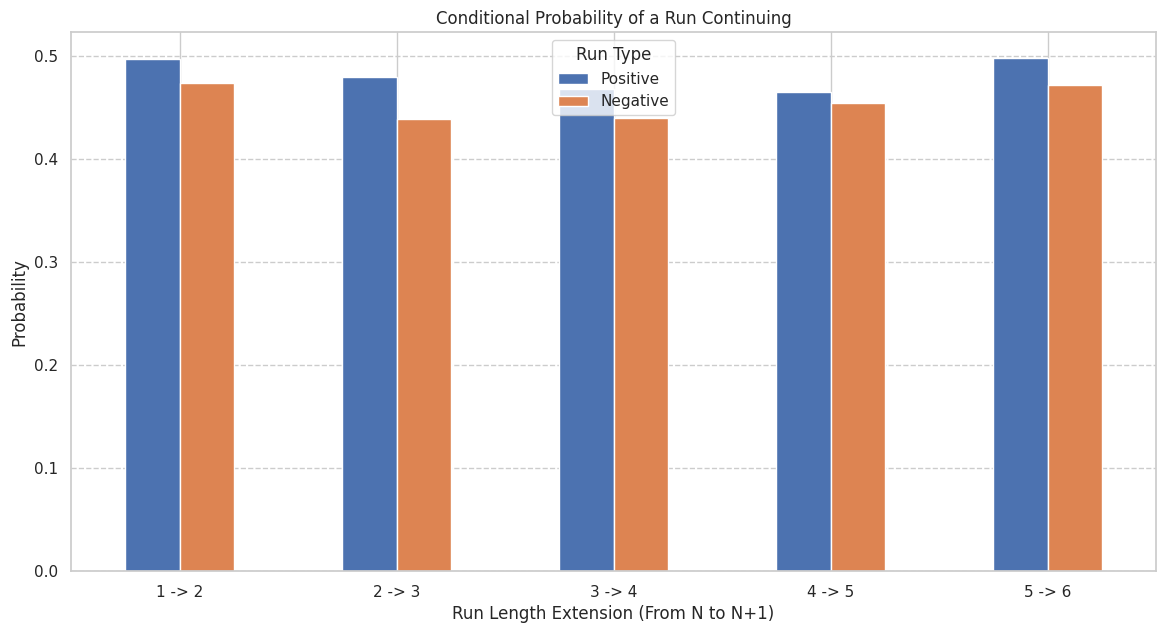

In [19]:
# Plot the continuation probabilities
print("\nPlotting the run continuation probabilities...")
prob_df.plot(kind='bar', figsize=(14, 7), rot=0)
plt.title('Conditional Probability of a Run Continuing')
plt.xlabel('Run Length Extension (From N to N+1)')
plt.ylabel('Probability')
plt.grid(axis='y', linestyle='--')
plt.legend(title='Run Type')
plt.show()

The bar chart shows the probability that a run of length N will extend to N+1. For both positive and negative runs, the probability of continuation is consistently below 0.5 and generally decreases as the run gets longer. This reinforces the idea of mean reversion in the hourly price changes; the longer a directional streak continues, the more likely it is to break.

## 6. Buy and Hold Performance Metrics

This section calculates standard performance metrics for a simple "buy and hold" strategy over the entire dataset. This provides a baseline against which any active trading strategy can be compared.

In [20]:
print("Calculating Buy and Hold performance metrics...")

# --- 1. Calculate Daily Returns ---
# Resample hourly data to daily data to get daily returns
daily_close = df['close'].resample('D').last()
daily_returns = daily_close.pct_change().dropna()

# --- 2. Define Parameters ---
risk_free_rate = 0.0
annualization_factor = 365 # Using 365 for crypto markets

# --- 3. Calculate Metrics ---
# Total Return
total_return = (df['close'].iloc[-1] / df['close'].iloc[0]) - 1

# Annualized Volatility
annualized_volatility = daily_returns.std() * np.sqrt(annualization_factor)

# Sharpe Ratio
if annualized_volatility > 0:
    sharpe_ratio = (daily_returns.mean() * annualization_factor - risk_free_rate) / annualized_volatility
else:
    sharpe_ratio = 0

# Max Drawdown
cumulative_returns = (1 + daily_returns).cumprod()
peak = cumulative_returns.expanding(min_periods=1).max()
drawdown = (cumulative_returns / peak) - 1
max_drawdown = drawdown.min()

# --- 4. Print Results ---
print("\n--- Buy and Hold Performance Summary ---")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Calculating Buy and Hold performance metrics...

--- Buy and Hold Performance Summary ---
Total Return: 31995.25%
Annualized Volatility: 70.72%
Sharpe Ratio: 1.16
Maximum Drawdown: -83.27%


In [21]:
c = df.close.values
first_trading_bar = 0
(c[-1] - c[first_trading_bar]) / c[first_trading_bar] * 100

31995.24590163934